## Init

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path+'/src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\new-peak-project\src


In [2]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [3]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

## Notebook Parameters

In [4]:
import os 

### parameters 

notebook_name = 'exp19_model_topology' # name of the notebook

## Generation of ground truth model 

model_name = 'v4_drug_model' # name of the model
o_random_seed = 5
# p_overall_seed = 46 # different seed for parameter generation
no_observable_species = 5
no_feedback_regulations = 2
specie_value_range = (1000, 5000)
param_range = (0.8, 1.2)
param_multiplier_range = (0.99, 1.01)


## Simulation parameters 

simulation_time = 1000 
simulation_step = 100

## Feature data generation 

feature_generation_method = 'lhs'
feature_generation_extra_params = {'min': 0.1, 'max': 10}
feature_generation_size = 1000 
feature_generation_seed = 50 # if -1 then 'o_random_seed' is used
if feature_generation_seed == -1:
    feature_generation_seed = o_random_seed
    
## Data engineering parameters

# Suboptimal Model Generation 

'''
Options: 
- 'feedback_prune': removes feedback regulations from the model 
- 'random parameter': randomizes a x% of parameter values of the model
'''

''' 
Options: 
- 'last_time_point' : only the last time point of the phosphorylated species is used
- 'dynamic_feature': computes the characteristic 'ten' dynamic feature for each specie data 
'''

## General parameters
parallelise = True
save_figures = True 
experiment_id = notebook_name + '_' + str(o_random_seed) + '_' + str(feature_generation_seed)
experiment_folder = config['DATA_PATH'] + '/' + experiment_id + '/'
if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)
    
print(experiment_folder)

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/exp19_model_topology_5_50/


## Analysis

### Virtual Cell Creation

In [5]:
# create a drug enabled model 
from models.Utils import *
from models.DrugModelSpecification import DrugModelSpecification, Drug

model_drug_spec = DrugModelSpecification()
model_drug_spec.generate_specifications(o_random_seed, no_observable_species, no_feedback_regulations, verbose=0)
drug_0 = Drug('D0', 500, 500)
rng = np.random.default_rng(o_random_seed)
# add random 'up' and 'down' regulations to the drug
regulation_dir = []
for i, s in enumerate(model_drug_spec.A_species):
    reg_type = str(rng.choice(['up', 'down']))
    regulation_dir.append(reg_type)
    drug_0.add_regulation(s, reg_type)
model_drug_spec.add_drug(drug_0)
print(model_drug_spec)
print(f'Feedback: {model_drug_spec.get_feedback_regulations()}')

A Species: ['A0', 'A1', 'A2', 'A3', 'A4']
B Species: ['B0', 'B1', 'B2', 'B3', 'B4']
C Species: ['C']
Regulations: [('B4', 'B3'), ('B4', 'B0'), ('A0', 'B0'), ('A1', 'B1'), ('A2', 'B2'), ('A3', 'B3'), ('A4', 'B4'), ('B0', 'C'), ('B1', 'C'), ('B2', 'C'), ('B3', 'C'), ('B4', 'C'), ('D0', 'A0'), ('D0', 'A1'), ('D0', 'A2'), ('D0', 'A3'), ('D0', 'A4')]
Regulation Types: ['up', 'down', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'down', 'down', 'down', 'down', 'up', 'down', 'up']
Drugs:
Drug(D0, 500, ['A0', 'A1', 'A2', 'A3', 'A4'], ['down', 'down', 'up', 'down', 'up'])

Feedback: [(('B4', 'B3'), 'up'), (('B4', 'B0'), 'down')]


In [6]:
p_random_seeds = []
feature_size = 1000 
rng = np.random.default_rng(o_random_seed)
# generate `feature_size` random seeds for different parameter sets using numpy, ensure that the seeds are unique
p_random_seeds = rng.choice(range(1000000), feature_size, replace=False).tolist()

In [7]:
G0_d = model_drug_spec.generate_network('drug_model_524', 
                                        specie_value_range, 
                                        param_range, 
                                        param_multiplier_range,  
                                        verbose=0,
                                        random_seed=p_random_seeds[0])
base_parameters = G0_d.get_parameters()
base_initial_conditions = G0_d.get_state_variables()

print(G0_d.get_antimony_model())

model drug_model_524

J0: A0p -> A0; J0_Vmax*A0p/(J0_Km + A0p)
J1: A0 -> A0p; J1_Vmax*A0/(J1_Km*(1+D0*J1_Kic0) + A0)
J2: A1p -> A1; J2_Vmax*A1p/(J2_Km + A1p)
J3: A1 -> A1p; J3_Vmax*A1/(J3_Km*(1+D0*J3_Kic0) + A1)
J4: A2p -> A2; J4_Vmax*A2p/(J4_Km + A2p)
J5: A2 -> A2p; (J5_Vmax+D0*J5_Kw0)*A2/(J5_Km + A2)
J6: A3p -> A3; J6_Vmax*A3p/(J6_Km + A3p)
J7: A3 -> A3p; J7_Vmax*A3/(J7_Km*(1+D0*J7_Kic0) + A3)
J8: A4p -> A4; J8_Vmax*A4p/(J8_Km + A4p)
J9: A4 -> A4p; (J9_Vmax+D0*J9_Kw0)*A4/(J9_Km + A4)
J10: B0p -> B0; J10_Vmax*B0p/(J10_Km + B0p)
J11: B0 -> B0p; (J11_Vmax+A0p*J11_Kw0)*B0/(J11_Km*(1+B4p*J11_Kic0) + B0)
J12: B1p -> B1; J12_Vmax*B1p/(J12_Km + B1p)
J13: B1 -> B1p; (J13_Vmax+A1p*J13_Kw0)*B1/(J13_Km + B1)
J14: B2p -> B2; J14_Vmax*B2p/(J14_Km + B2p)
J15: B2 -> B2p; (J15_Vmax+A2p*J15_Kw0)*B2/(J15_Km + B2)
J16: B3p -> B3; J16_Vmax*B3p/(J16_Km + B3p)
J17: B3 -> B3p; (J17_Vmax+B4p*J17_Kw0+A3p*J17_Kw1)*B3/(J17_Km + B3)
J18: B4p -> B4; J18_Vmax*B4p/(J18_Km + B4p)
J19: B4 -> B4p; (J19_Vmax+A4p*J19_Kw

In [8]:
parameter_sets = []
for p in p_random_seeds: 
    model_build = model_drug_spec.generate_network(f'param_seed_{p}', 
                                            specie_value_range, param_range, param_multiplier_range, random_seed=p, verbose=0)
    parameter_sets.append(model_build.get_parameters())

In [9]:
# test simulation 

from models.Solver.RoadrunnerSolver import RoadrunnerSolver

solver = RoadrunnerSolver()
solver.compile(G0_d.get_sbml_model())

original_result = solver.simulate(0, 1000, 100)
original_result

,time,A0p,A0,A1p,A1,A2p,A2,A3p,A3,A4p,...,B4p,B1p,B1,B2p,B2,B3p,B3,B4,C,Cp
0,0.00000,0.000000,3554.000000,0.000000,4841.000000,0.000000,4961.000000,0.000000,1859.000000,0.000000,...,0.000000,0.000000,3277.000000,0.000000,3131.000000,0.000000,1159.000000,2673.000000,100.000000,0.000000
1,10.10101,6.790443,3547.209557,6.849850,4834.150150,6.853854,4954.146146,6.594047,1852.405953,6.822963,...,9.488272,9.575252,3267.424748,9.561084,3121.438916,12.865493,1146.134507,2663.511728,95.142030,4.857970
2,20.20202,9.847902,3544.152098,9.936315,4831.063685,9.942274,4951.057726,9.555620,1849.444380,9.896300,...,16.832916,17.002153,3259.997847,16.977292,3114.022708,27.833494,1131.166506,2656.167084,92.431277,7.568723
3,30.30303,11.284281,3542.715719,11.387859,4829.612141,11.394841,4949.605159,10.941941,1848.058059,11.340979,...,21.950125,22.186427,3254.813573,22.153588,3108.846412,41.934600,1117.065400,2651.049875,91.388802,8.611198
4,40.40404,11.971675,3542.028325,12.083353,4828.916647,12.090880,4948.909120,11.602659,1847.397341,12.032806,...,25.354189,25.641925,3251.358075,25.603241,3105.396759,54.327001,1104.672999,2647.645811,91.170533,8.829467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,959.59596,4.655967,3549.344033,5.618449,4835.381551,4930.703886,30.296114,2.932693,1856.067307,4131.874670,...,2670.013052,20.319909,3256.680091,3128.490288,2.509712,1154.580733,4.419267,2.986948,93.588709,6.411291
96,969.69697,4.655967,3549.344033,5.618449,4835.381551,4930.703887,30.296113,2.932693,1856.067307,4131.874670,...,2670.013052,20.319909,3256.680091,3128.490288,2.509712,1154.580733,4.419267,2.986948,93.588709,6.411291
97,979.79798,4.655967,3549.344033,5.618449,4835.381551,4930.703888,30.296112,2.932693,1856.067307,4131.874670,...,2670.013052,20.319909,3256.680091,3128.490288,2.509712,1154.580733,4.419267,2.986948,93.588709,6.411291
98,989.89899,4.655967,3549.344033,5.618449,4835.381551,4930.703889,30.296111,2.932693,1856.067307,4131.874670,...,2670.013052,20.319909,3256.680091,3128.490288,2.509712,1154.580733,4.419267,2.986948,93.588709,6.411291


In [10]:
from models.Solver.ScipySolver import ScipySolver

solver = ScipySolver()
solver.compile(G0_d.get_antimony_model())
original_result = solver.simulate(0, 1000, 100)
original_result

,time,A0,A0p,A1,A1p,A2,A2p,A3,A3p,A4,...,B1,B1p,B2,B2p,B3,B3p,B4,B4p,C,Cp
0,0.00000,3554.000000,0.000000,4841.000000,0.000000,4961.000000,0.000000,1859.000000,0.000000,4162.000000,...,3277.000000,0.000000,3131.000000,0.000000,1159.000000,0.000000,2673.000000,0.000000,100.000000,0.000000
1,10.10101,3547.209555,6.790445,4834.150148,6.849852,4954.146144,6.853856,1852.405951,6.594049,4155.177035,...,3267.424751,9.575249,3121.438920,9.561080,1146.134510,12.865490,2663.511731,9.488269,95.142048,4.857952
2,20.20202,3544.152091,9.847909,4831.063678,9.936322,4951.057719,9.942281,1849.444373,9.555627,4152.103693,...,3259.997856,17.002144,3114.022716,16.977284,1131.166524,27.833476,2656.167093,16.832907,92.431319,7.568681
3,30.30303,3542.715703,11.284297,4829.612124,11.387876,4949.605143,11.394857,1848.058043,10.941957,4150.659004,...,3254.813585,22.186415,3108.846424,22.153576,1117.065439,41.934561,2651.049886,21.950114,91.388837,8.611163
4,40.40404,3542.028312,11.971688,4828.916634,12.083366,4948.909106,12.090894,1847.397329,11.602671,4149.967181,...,3251.358075,25.641925,3105.396759,25.603241,1104.673025,54.326975,2647.645811,25.354189,91.170548,8.829452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,959.59596,3549.344033,4.655967,4835.381551,5.618449,30.296115,4930.703885,1856.067307,2.932693,30.125330,...,3256.680091,20.319909,2.509712,3128.490288,4.419267,1154.580733,2.986948,2670.013052,93.588709,6.411291
96,969.69697,3549.344033,4.655967,4835.381551,5.618449,30.296115,4930.703885,1856.067307,2.932693,30.125330,...,3256.680091,20.319909,2.509712,3128.490288,4.419267,1154.580733,2.986948,2670.013052,93.588709,6.411291
97,979.79798,3549.344033,4.655967,4835.381551,5.618449,30.296115,4930.703885,1856.067307,2.932693,30.125330,...,3256.680091,20.319909,2.509712,3128.490288,4.419267,1154.580733,2.986948,2670.013052,93.588709,6.411291
98,989.89899,3549.344033,4.655967,4835.381551,5.618449,30.296115,4930.703885,1856.067307,2.932693,30.125330,...,3256.680091,20.319909,2.509712,3128.490288,4.419267,1154.580733,2.986948,2670.013052,93.588709,6.411291


### Perform parameter sensitivity analysis on original model

In [11]:
from sklearn.metrics import mean_squared_error

original_cp = original_result['Cp']
sensitivity_summary = []
parameters_list = G0_d.get_parameters()

for key, value in parameters_list.items():
    factor_range = np.arange(0.9, 1.11, 0.02)
    for factor in factor_range:
        new_value = value * factor
        solver.set_parameter_values({key: new_value})
        result = solver.simulate(0, 1000, 100)
        perturbed_cp = result['Cp']
        
        # Calculate RMSE or other metric
        euclid_norm = np.linalg.norm(original_cp - perturbed_cp)
        
        # Store result
        sensitivity_summary.append({
            'parameter': key,
            'factor': factor,
            'rmse': euclid_norm,
        })

# Convert to DataFrame
sensitivity_df = pd.DataFrame(sensitivity_summary)


In [12]:
# Compute mean Euclidean norm per parameter
rank_df = sensitivity_df.groupby('parameter')['rmse'].mean().reset_index()
rank_df = rank_df.sort_values(by='rmse', ascending=False)


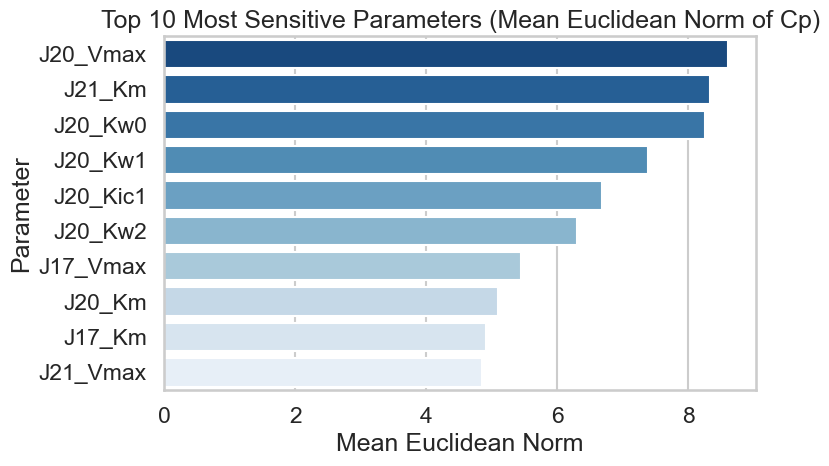

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute mean Euclidean norm and sort
rank_df = (
    sensitivity_df.groupby('parameter')['rmse']
    .mean()
    .reset_index()
    .sort_values(by='rmse', ascending=False)
)

# Select top 10
top10_df = rank_df.head(10)

# Plot
plt.figure(figsize=(8, 5))
sns.set(style="whitegrid", context="talk")

sns.barplot(
    data=top10_df,
    x='rmse',
    y='parameter',
    hue='parameter',
    palette='Blues_r',
)

plt.title("Top 10 Most Sensitive Parameters (Mean Euclidean Norm of Cp)")
plt.xlabel("Mean Euclidean Norm")
plt.ylabel("Parameter")
plt.tight_layout()
plt.show()


In [14]:
import re
import pandas as pd
from collections import defaultdict

def infer_phosphorylation_map(antimony_str):
    """
    Infers base species to phosphorylated form based on 'Xp' species in the model.
    """
    # Match all species names (A0, A0p, etc.)
    species = set(re.findall(r'\b[A-Za-z]\w*\b', antimony_str))
    
    mapping = {}
    for sp in species:
        if sp.endswith('p'):
            base = sp[:-1]
            if base in species:
                mapping[base] = sp
    return mapping


def map_regulations_to_parameters(antimony_str, regulations, regulation_types=None):
    """
    Map each regulation to its controlling parameters based on rate laws in the Antimony model.
    
    Parameters:
        antimony_str (str): Antimony model string.
        regulations (list of tuples): Each tuple is (regulator, target).
        regulation_types (list of str, optional): 'up' or 'down' for each regulation.
    
    Returns:
        pd.DataFrame: DataFrame with columns: ['regulator', 'target', 'type', 'parameters']
    """
    # Map regulators to their phosphorylated forms
    phosphorylated_form = infer_phosphorylation_map(antimony_str)

    # Parse reactions
    pattern = re.compile(r'(J\d+):\s*(\w+)\s*->\s*(\w+);\s*(.*)')
    reactions = pattern.findall(antimony_str)
    
    # Map target species to associated rate expressions
    target_to_rates = defaultdict(list)
    for rxn_id, reactant, product, rate_expr in reactions:
        target_to_rates[reactant].append((rxn_id, rate_expr))
    
    results = []
    for i, (reg, tgt) in enumerate(regulations):
        reg_form = phosphorylated_form.get(reg, reg)
        r_type = regulation_types[i] if regulation_types else "unknown"
        matched_params = set()

        # Search all rate expressions that involve the target
        for rxn_id, rate_expr in target_to_rates.get(tgt, []):
            # Match: reg_form * param or param * reg_form
            matches = re.findall(
                rf'\b{reg_form}\b\s*\*\s*(\w+)|(\w+)\s*\*\s*\b{reg_form}\b',
                rate_expr
            )
            found = [m[0] or m[1] for m in matches if m[0] or m[1]]
            matched_params.update(found)

        results.append({
            'regulator': reg,
            'target': tgt,
            'type': r_type,
            'parameters': sorted(matched_params) if matched_params else None
        })

    return pd.DataFrame(results)


In [15]:
import re
import pandas as pd

def extract_phosphorylation_as_regulations(antimony_str):
    """
    Extract phosphorylation reactions as regulator-target pairs with Vmax/Km.
    
    Returns:
        pd.DataFrame with columns: ['regulator', 'target', 'type', 'parameters']
    """
    rxn_pattern = re.compile(r'(J\d+):\s*(\w+)\s*->\s*(\w+);\s*(.*)')
    reactions = rxn_pattern.findall(antimony_str)

    records = []
    for rxn_id, reactant, product, rate_expr in reactions:
        # Heuristic: phosphorylation if product ends with 'p' and matches reactant + 'p'
        if product.endswith('p') and reactant == product[:-1]:
            vmax_match = re.search(r'([A-Za-z0-9_]*Vmax)', rate_expr)
            km_match = re.search(r'([A-Za-z0-9_]*Km)', rate_expr)

            vmax = vmax_match.group(1) if vmax_match else None
            km = km_match.group(1) if km_match else None
            params = list(filter(None, [vmax, km]))

            records.append({
                'regulator': reactant,
                'target': product,
                'type': 'phosphorylation',
                'parameters': params if params else None
            })

    return pd.DataFrame(records)


In [16]:
regulations = model_drug_spec.regulations
regulation_types = model_drug_spec.regulation_types

df = map_regulations_to_parameters(
    G0_d.get_antimony_model(),
    regulations,
    regulation_types
)

In [17]:
df

,regulator,target,type,parameters
0,B4,B3,up,[J17_Kw0]
1,B4,B0,down,[J11_Kic0]
2,A0,B0,up,[J11_Kw0]
3,A1,B1,up,[J13_Kw0]
4,A2,B2,up,[J15_Kw0]
5,A3,B3,up,[J17_Kw1]
6,A4,B4,up,[J19_Kw0]
7,B0,C,up,[J20_Kw0]
8,B1,C,up,[J20_Kw1]
9,B2,C,up,[J20_Kw2]


In [18]:
phospho_reg_df = extract_phosphorylation_as_regulations(G0_d.get_antimony_model())


In [19]:
phospho_reg_df

,regulator,target,type,parameters
0,A0,A0p,phosphorylation,"[J1_Vmax, J1_Km]"
1,A1,A1p,phosphorylation,"[J3_Vmax, J3_Km]"
2,A2,A2p,phosphorylation,"[J5_Vmax, J5_Km]"
3,A3,A3p,phosphorylation,"[J7_Vmax, J7_Km]"
4,A4,A4p,phosphorylation,"[J9_Vmax, J9_Km]"
5,B0,B0p,phosphorylation,"[J11_Vmax, J11_Km]"
6,B1,B1p,phosphorylation,"[J13_Vmax, J13_Km]"
7,B2,B2p,phosphorylation,"[J15_Vmax, J15_Km]"
8,B3,B3p,phosphorylation,"[J17_Vmax, J17_Km]"
9,B4,B4p,phosphorylation,"[J19_Vmax, J19_Km]"


In [20]:
# join two df into a new df called 'regulation_df' 
regulation_df = pd.concat([df, phospho_reg_df], ignore_index=True)

In [21]:
def rank_regulations_by_sensitivity(sensitivity_df, regulation_df):
    """
    Join sensitivity scores to regulations based on parameter names,
    and rank regulations by max sensitivity of any associated parameter.
    
    Returns:
        DataFrame with ['regulator', 'target', 'type', 'parameters', 'mean_rmse', 'max_rmse']
    """
    # Explode regulation parameters
    exploded = regulation_df.explode('parameters').dropna(subset=['parameters'])
    exploded = exploded.rename(columns={'parameters': 'parameter'})

    # Join with sensitivity values
    merged = pd.merge(exploded, sensitivity_df, on='parameter', how='left')

    # Aggregate sensitivity per regulation
    ranked = (
        merged.groupby(['regulator', 'target', 'type'])
        .agg(
            parameters=('parameter', lambda x: sorted(set(x))),
            mean_rmse=('rmse', 'mean'),
            max_rmse=('rmse', 'max')
        )
        .reset_index()
        .sort_values(by='max_rmse', ascending=False)
    )

    return ranked


In [22]:
model_str = G0_d.get_antimony_model() 

# Combine both regulation + phosphorylation regulation tables
all_regulations_df = pd.concat([
    map_regulations_to_parameters(model_str, regulations, regulation_types),
    extract_phosphorylation_as_regulations(model_str)
], ignore_index=True)

# Rank regulations
ranked_regs = rank_regulations_by_sensitivity(sensitivity_df, all_regulations_df)


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_sensitive_regulations(ranked_df, top_n=10):
    """
    Plot bar chart of top sensitive regulations by max_rmse.
    """
    # Create a readable label for the regulation
    ranked_df['label'] = ranked_df['regulator'] + " → " + ranked_df['target'] + " (" + ranked_df['type'] + ")"

    # Select top N
    top_df = ranked_df.nlargest(top_n, 'mean_rmse')

    # Plot
    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid", context="talk")

    sns.barplot(
        data=top_df,
        x='mean_rmse',
        y='label',
        palette='Reds_r',
        hue='label',
    )

    plt.xlabel("Mean Euclidean Norm (Cp deviation)")
    plt.ylabel("Regulation")
    plt.title(f"Top {top_n} Most Sensitive Regulations")
    plt.tight_layout()
    plt.show()


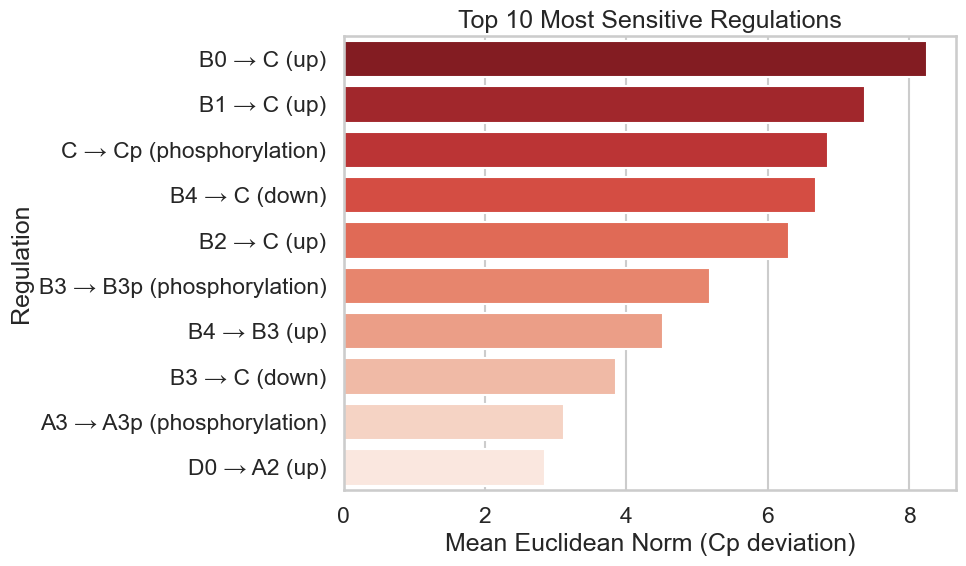

In [24]:
plot_top_sensitive_regulations(ranked_regs, top_n=10)


### Generate synthetic 'omics-like' data

In [25]:
from models.SyntheticGen import generate_feature_data, generate_target_data, generate_feature_data_v2, generate_target_data_diff_build

feature_data = generate_feature_data_v2(model_drug_spec, base_initial_conditions, feature_generation_method, feature_generation_extra_params, 1000, feature_generation_seed)
target_data, _ = generate_target_data_diff_build(model_drug_spec, solver, 
                                                 feature_data, parameter_sets, 
                                                 {'start': 0, 'end': 1000, 'points': 100}, 
                                                 n_cores=1, verbose=True)


Simulating perturbations: 100%|██████████| 1000/1000 [00:12<00:00, 82.76it/s]


In [26]:
feature_data.shape, target_data.shape


((1000, 10), (1000, 1))

In [27]:
feature_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A0      1000 non-null   float64
 1   A1      1000 non-null   float64
 2   A2      1000 non-null   float64
 3   A3      1000 non-null   float64
 4   A4      1000 non-null   float64
 5   B0      1000 non-null   float64
 6   B1      1000 non-null   float64
 7   B2      1000 non-null   float64
 8   B3      1000 non-null   float64
 9   B4      1000 non-null   float64
dtypes: float64(10)
memory usage: 78.3 KB


In [28]:
target_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Cp      1000 non-null   float64
dtypes: float64(1)
memory usage: 7.9 KB


In [29]:
pd.to_pickle(feature_data, config["DATA_PATH"] + "/presentations/feature_data_v1.pkl")
pd.to_pickle(target_data, config["DATA_PATH"] + "/presentations/target_data_v1.pkl")

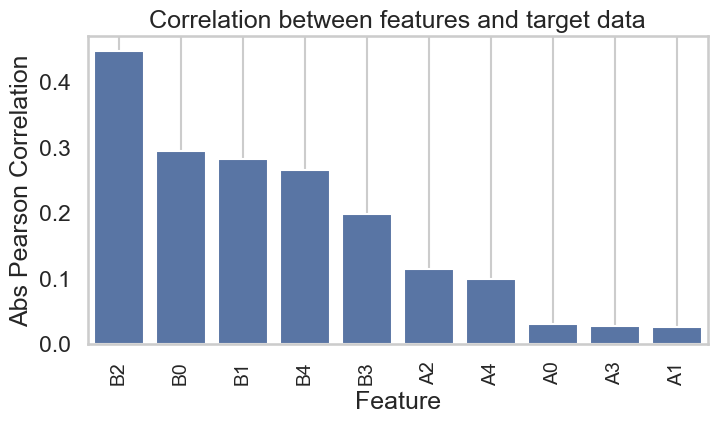

In [30]:
# plot the association between the features and the target data in a bar chart based on the correlation values 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# create a dataframe with the feature data and target data
feature_data_df = pd.DataFrame(feature_data)
target_data_df = pd.DataFrame(target_data)
# add the target data to the feature data
feature_data_df['target'] = target_data_df['Cp']

# calculate the correlation between the features and the target data
correlation = feature_data_df.corr()['target'].sort_values(ascending=False)
# create a dataframe with the correlation values
correlation_df = pd.DataFrame(correlation)
correlation_df = correlation_df.reset_index()
correlation_df.columns = ['feature', 'correlation']
# do not include the target data in the correlation dataframe
correlation_df = correlation_df[correlation_df['feature'] != 'target']
abs_correlation_df = correlation_df.copy()
# take the absolute value of the correlation
abs_correlation_df['correlation'] = abs(abs_correlation_df['correlation'])
# sort the dataframe by the absolute value of the correlation
abs_correlation_df = abs_correlation_df.sort_values(by='correlation', ascending=False)
abs_correlation_df_50 = abs_correlation_df.head(50)

sns.set_context("talk", rc={"font": "Arial"})
sns.set_style('whitegrid')

# plot the correlation values
plt.figure(figsize=(8, 4))
sns.barplot(x='feature', y='correlation', data=abs_correlation_df_50)
plt.title('Correlation between features and target data')
plt.xlabel('Feature')
plt.ylabel('Abs Pearson Correlation')
plt.xticks(rotation=90, fontsize=14)
plt.grid()
plt.show()

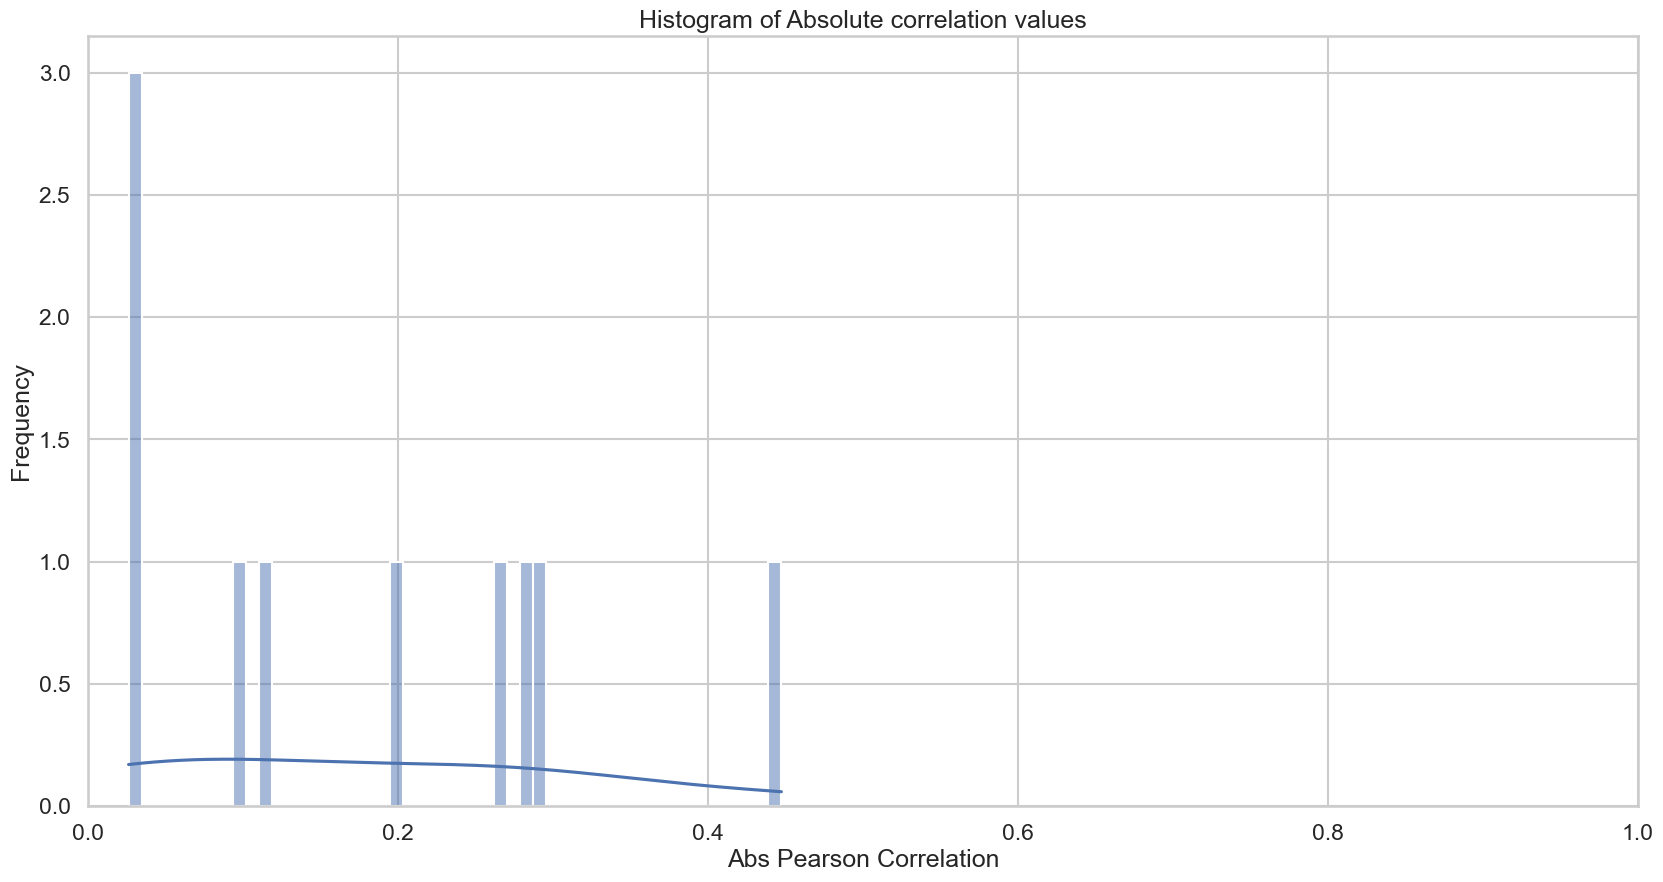

In [31]:
# make a histogram of the correlation values
plt.figure(figsize=(20, 10))
sns.histplot(abs_correlation_df['correlation'], bins=50, kde=True)
plt.title('Histogram of Absolute correlation values')
plt.xlabel('Abs Pearson Correlation')
plt.ylabel('Frequency')
plt.xlim(0,1)
plt.show()

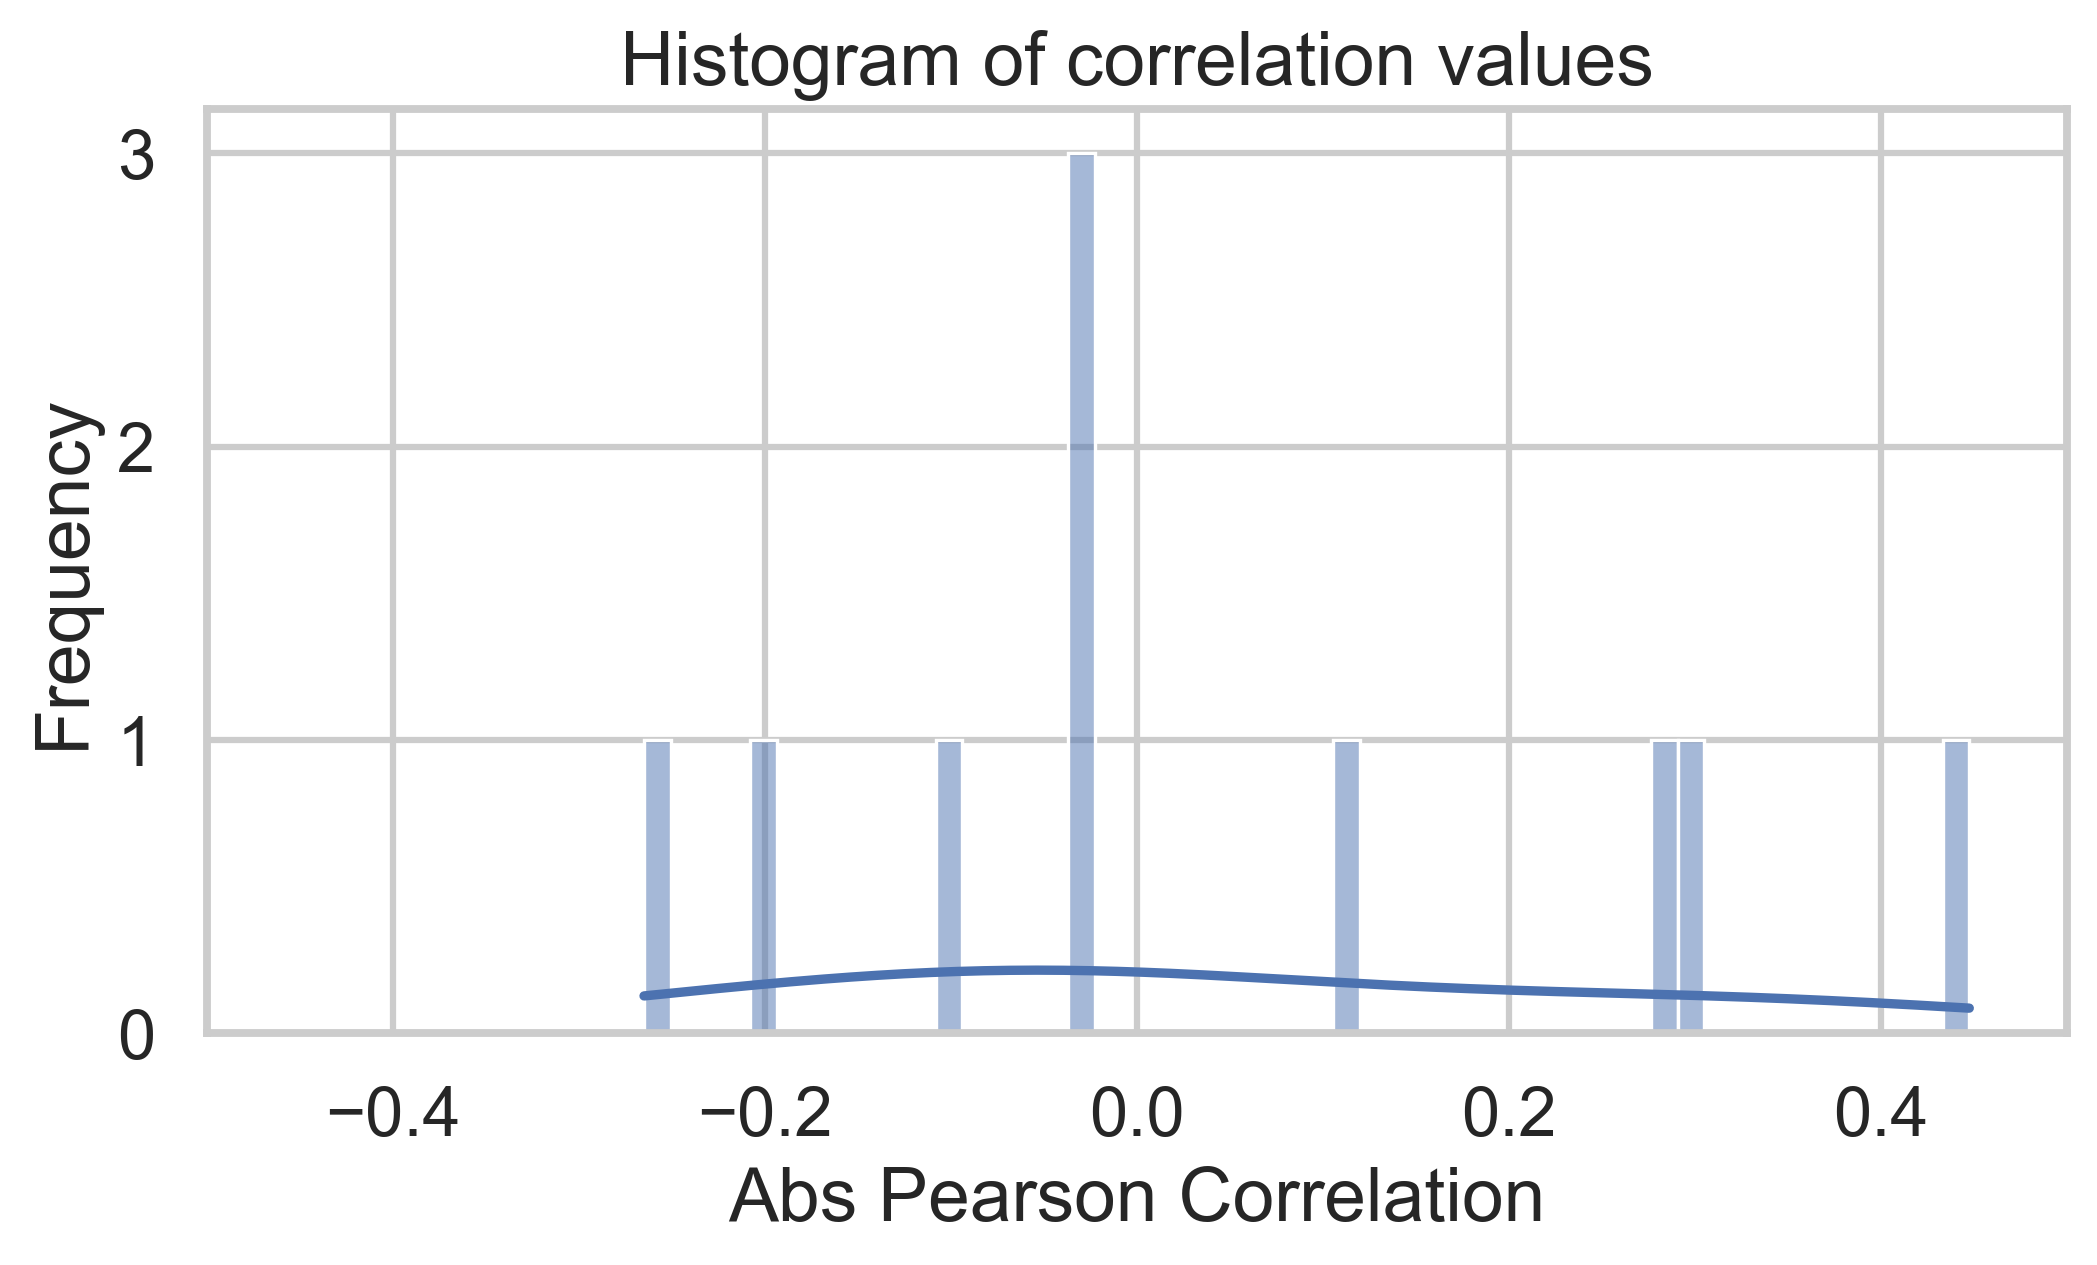

In [32]:
# make a histogram of the correlation values
sns.set_context("talk", rc={"font": "Arial"})
sns.set_style('whitegrid')
plt.figure(figsize=(8, 4), dpi=300)
sns.histplot(correlation_df['correlation'], bins=50, kde=True)
plt.title('Histogram of correlation values')
plt.xlabel('Abs Pearson Correlation')
plt.ylabel('Frequency')
plt.xlim(-0.5,0.5)
plt.show()

In [33]:
# extract the mean and standard deviation of the correlation values
mean = np.mean(correlation_df['correlation'])
std = np.std(correlation_df['correlation'])
max_val = np.max(correlation_df['correlation'])
min_val = np.min(correlation_df['correlation'])
outliers = correlation_df[(correlation_df['correlation'] > mean + 3*std) | (correlation_df['correlation'] < mean - 3*std)]

print(f'Mean: {mean:.4f}')
print(f'Standard Deviation: {std:.4f}')
print(f'Max: {max_val:.4f}')
print(f'Min: {min_val:.4f}')
print(f'Outliers as a ratio of all features: {outliers.shape[0] / correlation_df.shape[0]:.4f}')

Mean: 0.0492
Standard Deviation: 0.2186
Max: 0.4475
Min: -0.2650
Outliers as a ratio of all features: 0.0000


10 features selected based on correlation with target data


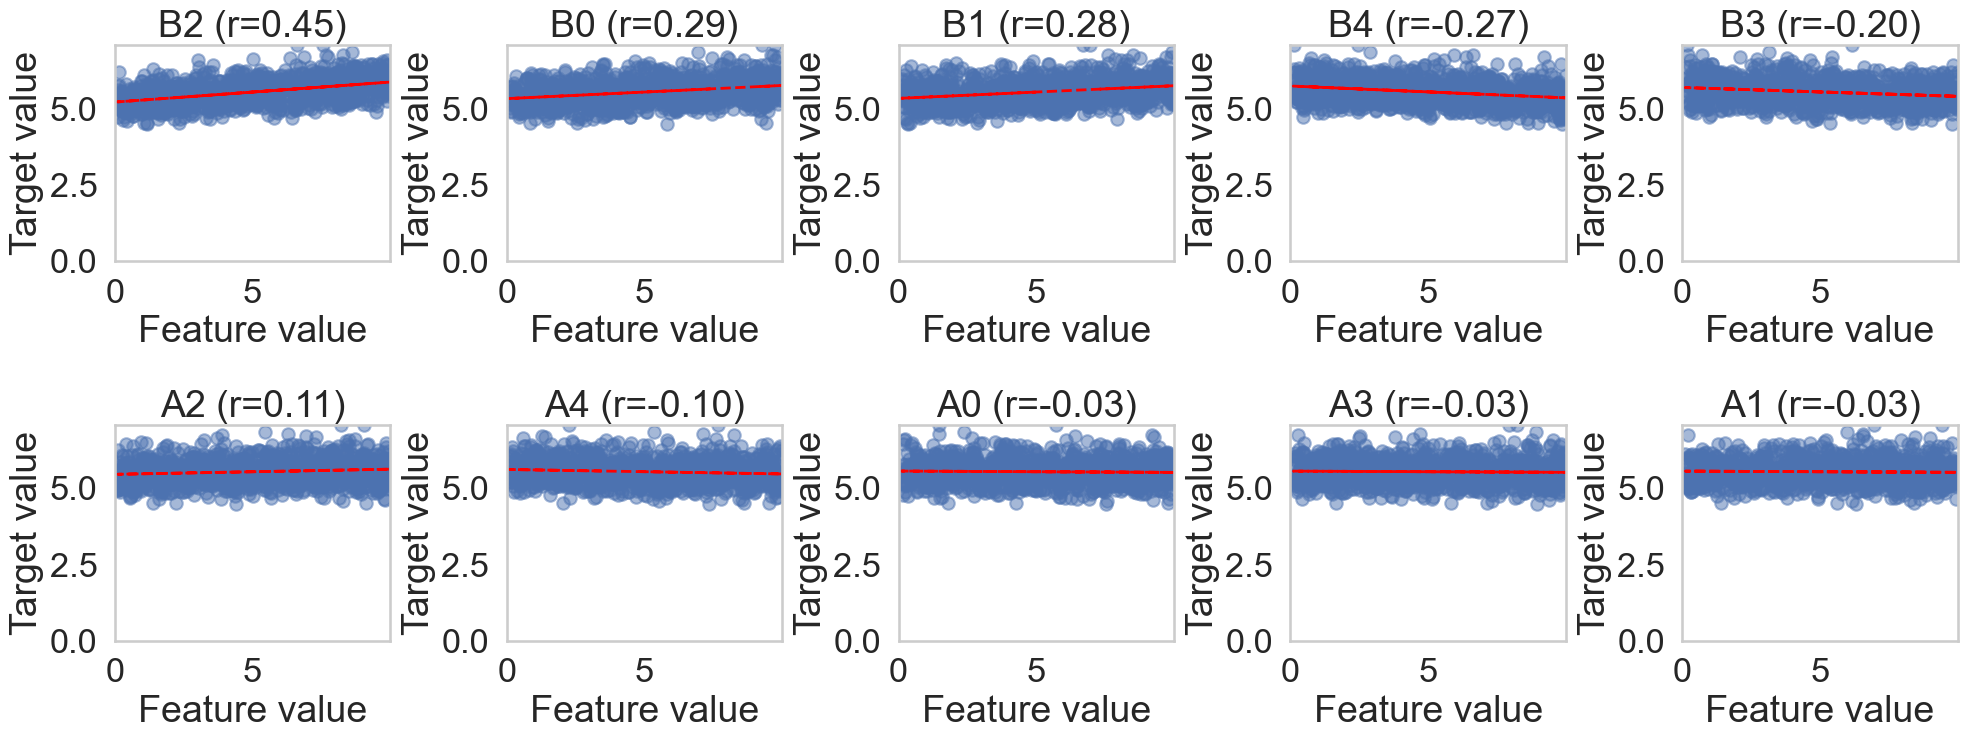

In [34]:
# plot association between the features and the target data 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# for each feature, plot the association with the target data, which is only a series 
# plot all features in separate subplots
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.5) 

n_features = len(feature_data.columns)
# plot only the top 10 features based on the absolute correlation values
top_features = abs_correlation_df['feature'].values[:10]
# create a new dataframe with only the top features
top_feature_data = feature_data[top_features]
print(f'{len(top_feature_data.columns)} features selected based on correlation with target data')
# make a subplot based on the size of feature_data, have five columns and as many rows as needed
top_n_features = len(top_feature_data.columns)
n_rows = int(top_n_features / 5) if top_n_features % 5 == 0 else int(top_n_features / 5) + 1
n_cols = 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
axs = axs.flatten()


# plot each feature in a separate subplot
for i, feature in enumerate(top_feature_data.columns):
    x = top_feature_data[feature].values.ravel()  # ensure 1D
    y = target_data.values.ravel()            # ensure 1D
    axs[i].scatter(x, y, alpha=0.5)
    # add a dash linear regression line with a pearson correlation coefficient
    # compute the pearson correlation coefficient
    corr, _ = pearsonr(x, y)
    # add a linear regression line
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    y_pred = model.predict(x.reshape(-1, 1))
    axs[i].plot(x, y_pred, color='red', linestyle='--', linewidth=2)
    axs[i].set_title(f'{feature} (r={corr:.2f})')

    axs[i].set_xlabel('Feature value')
    axs[i].set_ylabel('Target value')
    axs[i].grid()
    # set the x and y limits to be the same for all subplots
    max_feature = top_feature_data[feature].values.max()   
    max_target = target_data.values.max()  
    axs[i].set_xlim([0,max_feature])
    axs[i].set_ylim([0,max_target])
    # compute the correlation between the feature and target data
plt.tight_layout()
plt.show()

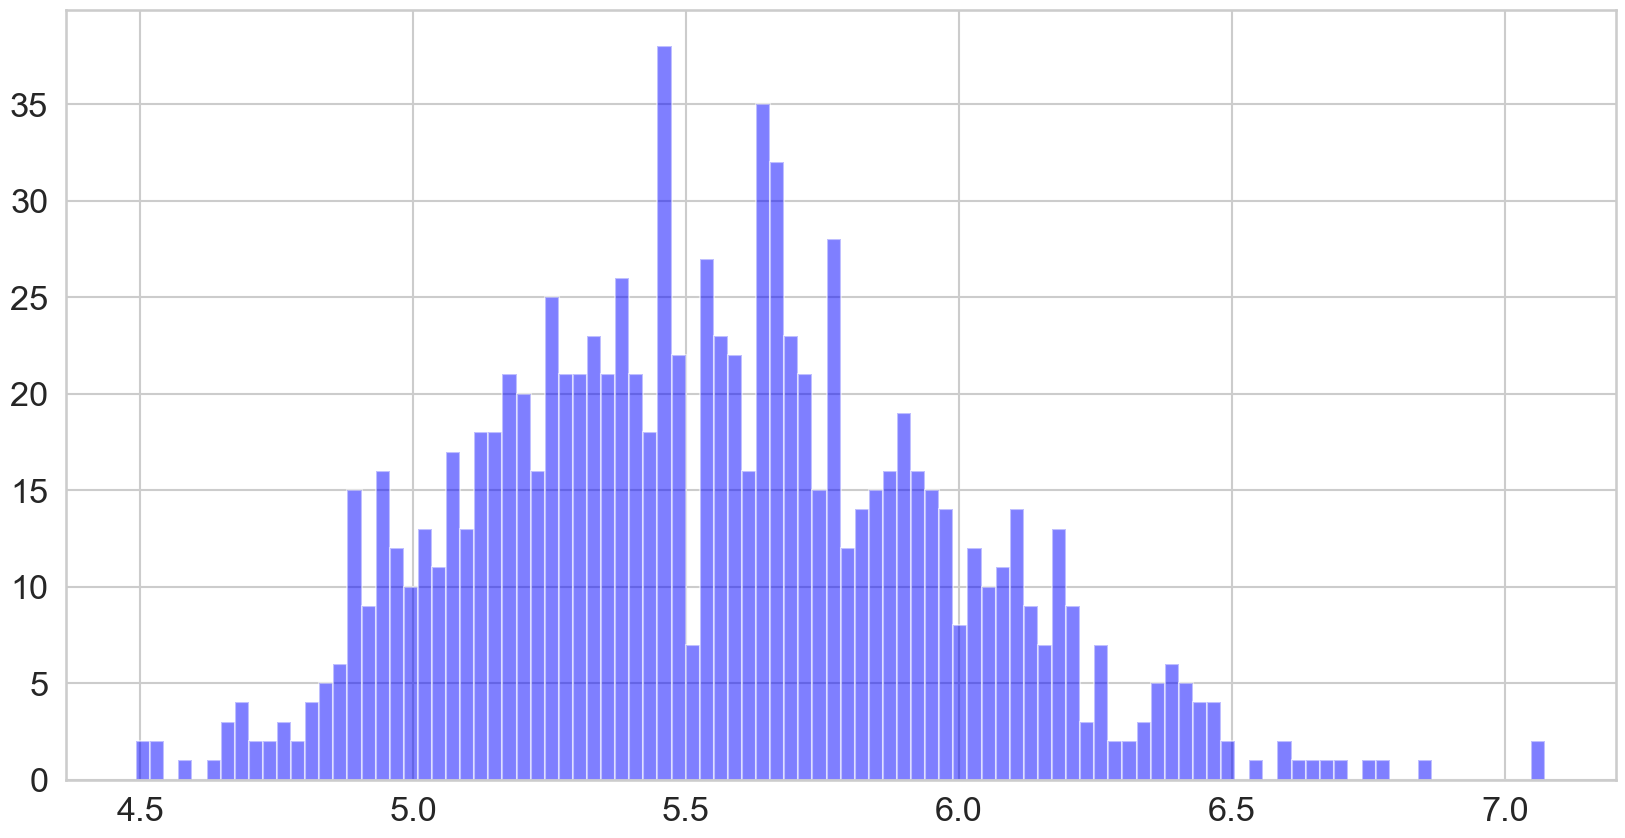

In [35]:
# plot the target data only with the x axis being 0 to 100 
plt.figure(figsize=(20, 10))
plt.hist(target_data, bins=100, alpha=0.5, color='blue')
plt.show()

### Suboptimal Model Creation

#### If modifying at the model architectural level

Mostly done to modify the `ModelSpec` object, where the updated spec information is transferred to a new `ModelBuilder` object, which then need to transpile to Antimony/SBML for a Solver instance. 

NewSpec --> NewBuilder --> Update parameters to original builder --> Transpile to Antimony/SBML --> Solver instance

#### If only changes to states and parameters are needed

Simply duplicate the `ModelBuilder` object and update the states and parameters.
```


#### Vary different specifications

In [36]:
parameter_list = G0_d.get_parameters()
# make all parameters to zero
zero_parameter_list = {k: 0 for k in parameter_list.keys() if 'Km' not in k}
# make 1000 copies of the zero parameter list
zero_parameter_sets = [deepcopy(zero_parameter_list) for _ in range(1000)]


#### Vary by removing specific parameters

In [37]:
# sort by mean rmse
ranked_regs = ranked_regs.sort_values(by='mean_rmse', ascending=False)
ranked_regs

,regulator,target,type,parameters,mean_rmse,max_rmse,label
11,B0,C,up,[J20_Kw0],8.248244,9.164169,B0 → C (up)
13,B1,C,up,[J20_Kw1],7.375607,8.734717,B1 → C (up)
22,C,Cp,phosphorylation,"[J20_Km, J20_Vmax]",6.846581,8.966023,C → Cp (phosphorylation)
21,B4,C,down,[J20_Kic1],6.680258,8.217853,B4 → C (down)
15,B2,C,up,[J20_Kw2],6.302871,9.614915,B2 → C (up)
16,B3,B3p,phosphorylation,"[J17_Km, J17_Vmax]",5.175712,6.435307,B3 → B3p (phosphorylation)
19,B4,B3,up,[J17_Kw0],4.521554,7.398798,B4 → B3 (up)
17,B3,C,down,[J20_Kic0],3.845101,6.430502,B3 → C (down)
6,A3,A3p,phosphorylation,"[J7_Km, J7_Vmax]",3.119137,4.689654,A3 → A3p (phosphorylation)
25,D0,A2,up,[J5_Kw0],2.842036,2.942254,D0 → A2 (up)


In [38]:
all_link_removal_parameters = []
parameters_to_zero = set()
# iterate ranked_regs from the top and remove the parameters that are in the zero_parameter_sets
for index, row in ranked_regs.iterrows():
    link_removal_parameter_sets = []
    parameters = row['parameters']
    for param in parameters:
        # if the parameter comtains 'Km' then skip it
        if 'Km' in param:
            continue
        parameters_to_zero.add(param)
    print(f'length of parameters to zero: {len(parameters_to_zero)}')
    for all_params in parameter_sets:
        if parameters is not None:
            new_params = all_params.copy()
            for zero_param in parameters_to_zero:
                if zero_param in all_params:
                    new_params[zero_param] = 0
            link_removal_parameter_sets.append(new_params)
    all_link_removal_parameters.append(link_removal_parameter_sets)
    
print(f'Number of link removal parameter sets: {len(all_link_removal_parameters)}')
            

length of parameters to zero: 1
length of parameters to zero: 2
length of parameters to zero: 3
length of parameters to zero: 4
length of parameters to zero: 5
length of parameters to zero: 6
length of parameters to zero: 7
length of parameters to zero: 8
length of parameters to zero: 9
length of parameters to zero: 10
length of parameters to zero: 11
length of parameters to zero: 12
length of parameters to zero: 13
length of parameters to zero: 14
length of parameters to zero: 15
length of parameters to zero: 16
length of parameters to zero: 17
length of parameters to zero: 18
length of parameters to zero: 19
length of parameters to zero: 20
length of parameters to zero: 21
length of parameters to zero: 22
length of parameters to zero: 23
length of parameters to zero: 24
length of parameters to zero: 25
length of parameters to zero: 26
length of parameters to zero: 27
length of parameters to zero: 28
Number of link removal parameter sets: 28


### Simulation / Extract dynamic feature data

In [39]:
# Minor distortion of the parameters to create a new set of parameters

rng = np.random.default_rng(o_random_seed)
modified_parameter_sets = []
for params in parameter_sets:
    new_params = {}
    for key, value in params.items(): 
        new_params[key] = value * rng.uniform(0.25, 4) # distortion range, expectation is that the larger the worse the model performance 
    modified_parameter_sets.append(new_params)

In [40]:
from models.SyntheticGen import generate_model_timecourse_data_diff_build

# generate the timecourse data for the new model
time_course_data = generate_model_timecourse_data_diff_build(model_drug_spec, 
                                                  solver, 
                                                  feature_data, 
                                                  modified_parameter_sets,
                                                  {'start': 0, 'end': 1000, 'points': 100}, 
                                                  capture_species='all', n_cores=1, verbose=True)


Simulating perturbations: 100%|██████████| 1000/1000 [00:20<00:00, 48.19it/s]


In [41]:
time_course_data.shape

(1000, 22)

In [42]:
time_course_data

,A0,A0p,A1,A1p,A2,A2p,A3,A3p,A4,A4p,...,B1,B1p,B2,B2p,B3,B3p,B4,B4p,C,Cp
0,"[9.982304515350323, 9.648434057075754, 9.51729...","[0.0, 0.33387045827456385, 0.4650128968358181,...","[0.4382466735876226, 0.4134676487893285, 0.404...","[0.0, 0.024779024798294205, 0.0336980166410675...","[6.371175745844176, 5.495336945862889, 4.98619...","[0.0, 0.8758387999812868, 1.3849815449015694, ...","[9.010262853948213, 8.22728566490191, 7.777046...","[0.0, 0.7829771890462999, 1.2332160471492912, ...","[4.780355347776668, 4.734752006787579, 4.70686...","[0.0, 0.04560334098908771, 0.07349374971637283...",...,"[4.980056241896318, 4.949038314840855, 4.94897...","[0.0, 0.031017927055463287, 0.0310790468585357...","[2.1734997816941464, 1.6788158585550446, 1.418...","[0.0, 0.49468392313910214, 0.7547833556255853,...","[9.867316660917776, 8.354137210462312, 7.37129...","[0.0, 1.5131794504554723, 2.496025726007183, 3...","[6.8788669386058166, 6.7969885456919465, 6.731...","[0.0, 0.0818783929138738, 0.14724190539504198,...","[100.0, 91.59085095029664, 88.7292062032346, 8...","[0.0, 8.409149049703325, 11.270793796765325, 1..."
1,"[5.73323184522851, 5.632250260386587, 5.573341...","[0.0, 0.10098158484192403, 0.15989056022841672...","[6.362766555090388, 6.230323499106262, 6.15957...","[0.0, 0.13244305598412734, 0.20318744175368836...","[6.472348283707556, 6.07391918136215, 5.848485...","[0.0, 0.398429102345408, 0.6238630473625613, 0...","[2.5737609457949793, 2.5306593820924546, 2.509...","[0.0, 0.043101563702522896, 0.0638021807875627...","[5.266696567772818, 4.938264250640313, 4.75168...","[0.0, 0.32843231713250615, 0.5150094161190178,...",...,"[2.7078684986141734, 2.6551572858735817, 2.617...","[0.0, 0.05271121274059113, 0.09042745281883666...","[3.7442682833050687, 2.9268608614270217, 2.838...","[0.0, 0.8174074218780475, 0.9058511723535659, ...","[9.623650706207354, 9.141966653034208, 9.10827...","[0.0, 0.48168405317314045, 0.5153781348750824,...","[4.608462983112409, 4.521322327171865, 4.45971...","[0.0, 0.08714065594053937, 0.14874781537707268...","[100.0, 92.21212423079393, 85.79383517355006, ...","[0.0, 7.787875769206099, 14.20616482644997, 18..."
2,"[4.065739783125794, 3.642663459639867, 3.46183...","[0.0, 0.42307632348592517, 0.6039044028394017,...","[2.5713000642454884, 2.3397931577942233, 2.285...","[0.0, 0.23150690645126645, 0.28532855257066053...","[0.18210555990740018, 0.1529691988308784, 0.14...","[0.0, 0.029136361076521792, 0.0352684615813874...","[5.831492059789114, 5.248696010019867, 4.95848...","[0.0, 0.5827960497692479, 0.8730110879949929, ...","[6.889065483718838, 6.181606147152999, 6.05625...","[0.0, 0.7074593365658377, 0.8328132518446406, ...",...,"[6.451358755553173, 6.138419578263058, 6.08449...","[0.0, 0.3129391772901129, 0.36686729499229814,...","[2.2252164407477264, 1.6068389026543641, 1.574...","[0.0, 0.6183775380933626, 0.6507537751478696, ...","[8.408359713372244, 7.847138912661689, 7.72297...","[0.0, 0.5612208007105526, 0.6853857214850666, ...","[4.758216381362555, 4.669981389337023, 4.65808...","[0.0, 0.08823499202553414, 0.10013409673827622...","[100.0, 96.87817345913821, 96.7757256024135, 9...","[0.0, 3.121826540861743, 3.2242743975864476, 3..."
3,"[3.814673877307333, 3.7701814666339177, 3.7681...","[0.0, 0.044492410673415, 0.04652828403531998, ...","[6.75156385654199, 6.394302302192687, 6.230860...","[0.0, 0.3572615543493052, 0.52070354398561, 0....","[5.192769586244278, 4.5804035700918515, 4.4889...","[0.0, 0.6123660161524278, 0.7038116264479437, ...","[1.8948031027817716, 1.4213676109555262, 1.353...","[0.0, 0.4734354918262448, 0.5414100837392415, ...","[8.171632906008975, 6.986369830562679, 6.19753...","[0.0, 1.1852630754462987, 1.9741001220141696, ...",...,"[9.493348842341264, 9.196698990306198, 9.19275...","[0.0, 0.2966498520350608, 0.3005922166189657, ...","[2.034370444489765, 1.4985536735108798, 1.3311...","[0.0, 0.5358167709788849, 0.7032215935064249, ...","[7.096634935953625, 6.884331704214225, 6.77545...","[0

In [43]:
time_course_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   A0      1000 non-null   object
 1   A0p     1000 non-null   object
 2   A1      1000 non-null   object
 3   A1p     1000 non-null   object
 4   A2      1000 non-null   object
 5   A2p     1000 non-null   object
 6   A3      1000 non-null   object
 7   A3p     1000 non-null   object
 8   A4      1000 non-null   object
 9   A4p     1000 non-null   object
 10  B0      1000 non-null   object
 11  B0p     1000 non-null   object
 12  B1      1000 non-null   object
 13  B1p     1000 non-null   object
 14  B2      1000 non-null   object
 15  B2p     1000 non-null   object
 16  B3      1000 non-null   object
 17  B3p     1000 non-null   object
 18  B4      1000 non-null   object
 19  B4p     1000 non-null   object
 20  C       1000 non-null   object
 21  Cp      1000 non-null   object
dtypes: object(22)
memory usag

In [44]:
true_time_course_data = generate_model_timecourse_data_diff_build(model_drug_spec, 
                                                            solver,
                                                            feature_data, 
                                                            parameter_sets, 
                                                            {'start': 0, 'end': 1000, 'points': 100}, 
                                                            capture_species='all', n_cores=1, verbose=True)

Simulating perturbations: 100%|██████████| 1000/1000 [00:12<00:00, 78.35it/s]


In [45]:
# link removal time course data (sets)

link_removal_time_course_datasets = []
for link_removal_params in all_link_removal_parameters:
    link_removal_time_course_data = generate_model_timecourse_data_diff_build(model_drug_spec, 
                                                                    solver, 
                                                                    feature_data, 
                                                                    link_removal_params, 
                                                                    {'start': 0, 'end': 1000, 'points': 100}, 
                                                                    capture_species='all', n_cores=1, verbose=True)
    link_removal_time_course_datasets.append(link_removal_time_course_data)

Simulating perturbations: 100%|██████████| 1000/1000 [00:01<00:00, 725.23it/s]


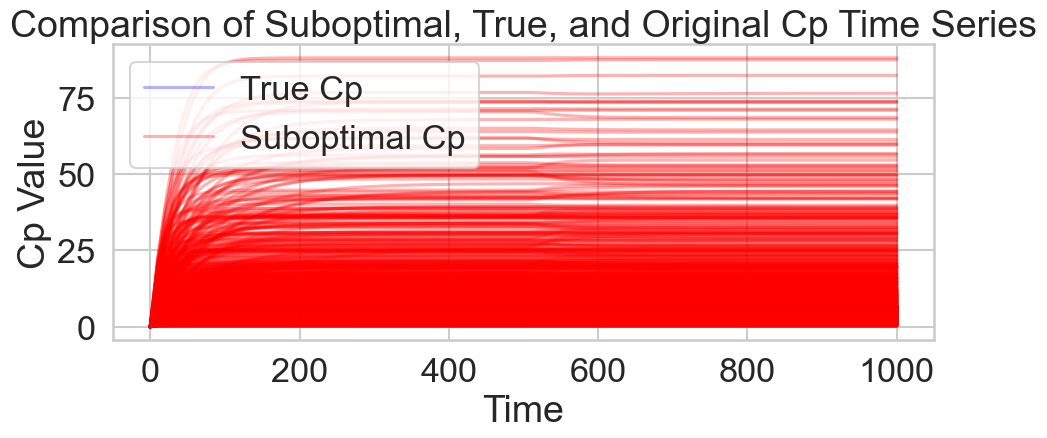

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Get time axis (assuming same length for both datasets)
n_steps = len(time_course_data['Cp'][0])
real_time = np.linspace(0, 1000, n_steps)

plt.figure(figsize=(10, 5))

# Plot true time course (blue)
for series in true_time_course_data['Cp']:
    plt.plot(real_time, series, alpha=0.3, color='blue', label='True Cp' if 'True Cp' not in plt.gca().get_legend_handles_labels()[1] else "")
    
# Plot simulated time course (red)
for series in time_course_data['Cp']:
    plt.plot(real_time, series, alpha=0.3, color='red', label='Suboptimal Cp' if 'Suboptimal Cp' not in plt.gca().get_legend_handles_labels()[1] else "")

# Labels and formatting
plt.title("Comparison of Suboptimal, True, and Original Cp Time Series")
plt.xlabel("Time")
plt.ylabel("Cp Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


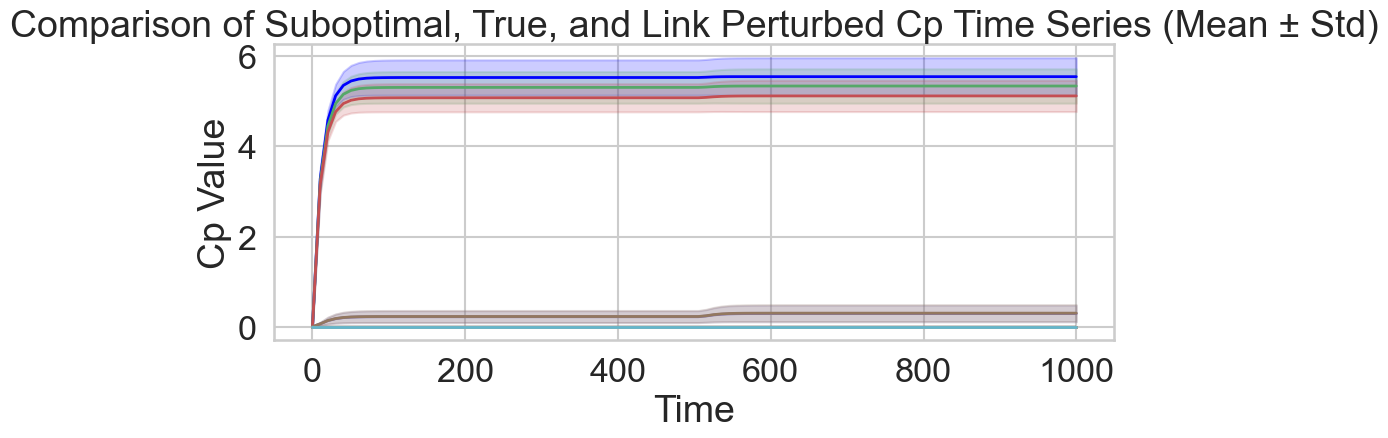

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# === Set up time axis ===
n_steps = len(time_course_data['Cp'][0])  # assumes all rows have equal length
real_time = np.linspace(0, 1000, n_steps)

# === Helper function to plot mean ± std ===
def plot_mean_std(df, color, label, time_axis):
    # Stack rows of lists into a 2D array: shape (n_replicates, time_steps)
    data = np.vstack(df['Cp'].values)
    mean = data.mean(axis=0)
    std = data.std(axis=0)

    # Plot mean line
    plt.plot(time_axis, mean, color=color, label=label, linewidth=2)
    # Plot shaded std band
    plt.fill_between(time_axis, mean - std, mean + std, color=color, alpha=0.2)

# === Begin Plot ===
plt.figure(figsize=(10, 5))

# Plot mean ± std for true data
plot_mean_std(true_time_course_data, color='blue', label='True Cp', time_axis=real_time)

# Plot mean ± std for simulated data
# plot_mean_std(time_course_data, color='red', label='Simulated Cp', time_axis=real_time)

# Plot mean ± std for link removal datasets
for i, link_removal_data in enumerate(link_removal_time_course_datasets):
    plot_mean_std(link_removal_data, color=f'C{i+2}', label=f'Link Removal Set {i+1}', time_axis=real_time)

# === Plot Settings ===
plt.title("Comparison of Suboptimal, True, and Link Perturbed Cp Time Series (Mean ± Std)")
plt.xlabel("Time")
plt.ylabel("Cp Value")
# plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Creating final datasets for ML Training

In [48]:
from models.Utils import last_time_point_method, dynamic_features_method

all_species = model_drug_spec.A_species + model_drug_spec.B_species + model_drug_spec.C_species
all_phos_species = [s+'p' for s in all_species]
# apply the data engineering method to the feature data
last_time_data = last_time_point_method(time_course_data, all_phos_species)

In [49]:
dynamic_data = dynamic_features_method(time_course_data, all_phos_species, n_cores=8)

In [50]:
combined_lp_data = pd.concat([feature_data, last_time_data], axis=1)
combined_dyn_data = pd.concat([feature_data, dynamic_data], axis=1)


In [51]:
feature_data_list = [feature_data, last_time_data, dynamic_data, combined_lp_data, combined_dyn_data]
feature_data_names = ['feature_data', 'last_time_data', 'dynamic_data', 'combined_lp_data', 'combined_dyn_data']

In [52]:
last_time_data_link_rm = []
dynamic_data_link_rm = []
for zeroed_params in link_removal_time_course_datasets:
    last_time_data_rm = last_time_point_method(zeroed_params, all_phos_species)
    dynamic_data_rm = dynamic_features_method(zeroed_params, all_phos_species, n_cores=8)
    last_time_data_link_rm.append(last_time_data_rm)
    dynamic_data_link_rm.append(dynamic_data_rm)
    
# combine the link removal data with the feature data
link_removal_last_time_combined = []
link_removal_dynamic_combined = []
for i in range(len(last_time_data_link_rm)):
    link_removal_last_time_combined.append(pd.concat([feature_data, last_time_data_link_rm[i]], axis=1))
    link_removal_dynamic_combined.append(pd.concat([feature_data, dynamic_data_link_rm[i]], axis=1))
    
# create labels for the link removal data
link_removal_last_time_labels = [f'link_removal_{i+1}_last_time' for i in range(len(last_time_data_link_rm))]
link_removal_dynamic_labels = [f'link_removal_{i+1}_dynamic' for i in range(len(dynamic_data_link_rm))]
# create labels for the combined data
combined_lp_labels = [f'link_removal_{i+1}_combined_lp' for i in range(len(link_removal_last_time_combined))]
combined_dyn_labels = [f'link_removal_{i+1}_combined_dyn' for i in range(len(link_removal_dynamic_combined))]

# add into feature_data_list and feature_data_names
feature_data_list.extend(last_time_data_link_rm)
feature_data_list.extend(dynamic_data_link_rm)
feature_data_list.extend(link_removal_last_time_combined)
feature_data_list.extend(link_removal_dynamic_combined)
feature_data_names.extend(link_removal_last_time_labels)
feature_data_names.extend(link_removal_dynamic_labels)
feature_data_names.extend(combined_lp_labels)
feature_data_names.extend(combined_dyn_labels)

### Machine Learning Training

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

def build_pipeline(model, scale=False):
    steps = [('imputer', SimpleImputer(strategy='mean'))]
    if scale:
        steps.append(('scaler', StandardScaler()))
    steps.append(('model', model))
    return Pipeline(steps)



def evaluate_model(model, model_name, feature_data, feature_data_name, target_data, test_size=0.2, random_state=4):
    # Align rows between X and y
    common_idx = feature_data.index.intersection(target_data.index)
    X = feature_data.loc[common_idx]
    y = target_data.loc[common_idx]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return {
        'Model': model_name, 
        'Feature Data': feature_data_name,
        'Mean Squared Error': mean_squared_error(y_test, y_pred),
        'R2 Score': r2_score(y_test, y_pred),
        'Pearson Correlation': pearsonr(y_test, y_pred)[0],
        'Pearson P-Value': pearsonr(y_test, y_pred)[1]
    }

all_models = [
    build_pipeline(LinearRegression()),
    build_pipeline(RandomForestRegressor(n_estimators=100, random_state=o_random_seed)),
    build_pipeline(GradientBoostingRegressor(n_estimators=100, random_state=o_random_seed)),
    build_pipeline(SVR(max_iter=10000), scale=True),
    build_pipeline(MLPRegressor(hidden_layer_sizes=(20,), max_iter=10000, random_state=o_random_seed), scale=True)
]

all_models_desc = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine', 'Neural Network']
zipped_model_data = list(zip(all_models, all_models_desc))
all_features = feature_data_list
all_features_desc = feature_data_names
zipped_feature_data = list(zip(all_features, all_features_desc))

# random states are rand ints between 0 and 10000, for n values 
np.random.seed(o_random_seed)
n_random = 10
all_random_states = np.random.randint(0, 10000, n_random)

parallelise = True 
from tqdm import tqdm
# tqdm is a progress bar library, use it to show the progress of the model evaluation
metric_data = []
if not parallelise:          
    for (feature_data, feature_data_name) in tqdm(zipped_feature_data):
        # print('Feature Data:', feature_data_name)
        # print('Feature Data Shape:', feature_data.shape)
        for (model, model_name) in zipped_model_data:
            # print('Model:', model_name)
            for rand in all_random_states:
                metrics = evaluate_model(model, model_name, feature_data, feature_data_name, target_data['Cp'], random_state=rand)
                metric_data.append(metrics)
                
else:        
    # parallelise the model evaluation process using joblib
    from joblib import Parallel, delayed

    metric_data = Parallel(n_jobs=-1)(delayed(evaluate_model)(model, model_name, feature_data, feature_data_name, target_data['Cp'], random_state=rand) 
                                    for (feature_data, feature_data_name) in zipped_feature_data
                                    for (model, model_name) in zipped_model_data
                                    for rand in all_random_states)

# make a dataframe of the metric data
metric_df = pd.DataFrame(metric_data)
metric_df

KeyboardInterrupt: 

In [ ]:
if save_figures: 
    metric_df.to_pickle(experiment_folder+'metric_df.pkl')
    print('Metric data saved to:', experiment_folder+'metric_df.pkl')   


In [ ]:
# load the metric data
import pandas as pd 
metric_df = pd.read_pickle(experiment_folder+'metric_df.pkl')
print('Metric data loaded from:', experiment_folder+'metric_df.pkl')

In [ ]:
import pandas as pd
import re

# Apply regex to extract parts from 'Feature Data'
def extract_link_removal_parts(feature_str):
    match = re.match(r'(link_removal_(\d+)_([\w]+))', feature_str)
    if match:
        full_name = match.group(1)
        removed_links = int(match.group(2))
        data_type = match.group(3)
        return pd.Series([full_name, removed_links, data_type])
    else:
        return pd.Series([feature_str, None, None])  # fallback for non-matching entries

# Apply to metric_df
metric_df[['Full name', 'Removed links', 'Type']] = metric_df['Feature Data'].apply(extract_link_removal_parts)



In [ ]:
metric_df

In [ ]:
# plot the pearson correlation for each feature data combination

import matplotlib.pyplot as plt
import seaborn as sns
# Set up the figure
plt.figure(figsize=(120, 6))
# Create a boxplot for Pearson Correlation
sns.boxplot(data=metric_df, x='Feature Data', y='Pearson Correlation', hue='Feature Data')
plt.xticks(rotation=45, ha='right')
plt.title('Pearson Correlation by Feature Data and Model')
plt.xlabel('Feature Data')
plt.ylabel('Pearson Correlation')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# FILL missing values of Pearson Correlation with 0 
metric_df['Pearson Correlation'] = metric_df['Pearson Correlation'].fillna(0)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("talk", rc={"font": "Arial"})
sns.set_style('whitegrid')

# Group and average
grouped = (
    metric_df
    .dropna(subset=['Removed links', 'Pearson Correlation', 'Type'])
    .groupby(['Removed links', 'Type'])
    .agg(mean_corr=('Pearson Correlation', 'mean'))
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped, x='Removed links', y='mean_corr', hue='Type', marker='o')
plt.title('Mean Pearson Correlation vs Removed Links')
plt.xlabel('Number of Links Removed')
plt.ylabel('Mean Pearson Correlation')
plt.tight_layout()
plt.show()
